# Tracker Simulated Hit Smearing Validation

### Omar Moreno, SLAC National Accelerator Laboratory

This notebook validates the hit smearing class `tracking::sim::HitSmearingProcessor`. A sample of 1000 single electron photo-nuclear events with hits in both the Tagger and Recoil tracker were used.  The following configuration was used to run the smearing algorithm on the resulting SimTrackerHits

```python

p = ldmxcfg.Process("sim")

p.libraries.append("libTracking.so")

from LDMX.Tracking import HitSmearingProcessor


smear_recoil = HitSmearingProcessor.HitSmearingProcessor()

smear_recoil.input_hit_coll  = 'RecoilSimHits'
smear_recoil.output_hit_coll = 'SmearedRecoilSimHits'

smear_recoil.sigma_u = 0.05
smear_recoil.sigma_v = 0.25

smear_tagger = HitSmearingProcessor.HitSmearingProcessor()

smear_tagger.input_hit_coll  = 'TaggerSimHits'
smear_tagger.output_hit_coll = 'SmearedTaggerSimHits'

smear_tagger.sigma_u = 0.05
smear_tagger.sigma_v = 0.25


p.sequence = [smear_tagger, smear_recoil]


p.inputFiles = ['input.root']
p.outputFiles = ['test.root'] 

p.maxEvents = 1000
````

In [1]:
import uproot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
def get_flattened_array(events, coll, var):
    array = events[coll]['%s.%s_' % (coll, var)].array(library='np')
    array = np.array([i for j in array for i in j])
    return array

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( -1 * (x - mean)**2 / (2*standard_deviation ** 2))

def gaussian_fit(ax, xmin, xmax, bin_centers, bin_heights, **kargs): 
    
    color = 'blue'
    if 'color' in kargs:
        color = kargs['color']
    
    x_fit_interval = np.linspace(xmin, xmax, 500)
    
    popt, _ = curve_fit(gaussian, bin_centers, 
                        bin_heights, p0=[1., 0., 1.])

    ax.plot(x_fit_interval, gaussian(x_fit_interval, *popt),
            color=color, lw=2)
    
    return popt[0], -1*popt[2]

In [3]:
# Grab the LDMX_Events tree
events = uproot.open('smear.root:LDMX_Events')

#
# Grab a structured array of x-y sim hit positions for the tagger and
# recoil tracker.  The list is then flattened to facilitate plotting.
#

#
# Tagger
#
tag_x = get_flattened_array(events, 'TaggerSimHits_sim', 'x')
stag_x = get_flattened_array(events, 'SmearedTaggerSimHits_sim', 'x')
tag_y = get_flattened_array(events, 'TaggerSimHits_sim', 'y')
stag_y = get_flattened_array(events, 'SmearedTaggerSimHits_sim', 'y')

tag_xres = tag_x - stag_x
tag_yres = tag_y - stag_y

#
# Recoil
#
rec_x = get_flattened_array(events, 'RecoilSimHits_sim', 'x')
srec_x = get_flattened_array(events, 'SmearedRecoilSimHits_sim', 'x')
rec_y = get_flattened_array(events, 'RecoilSimHits_sim', 'y')
srec_y = get_flattened_array(events, 'SmearedRecoilSimHits_sim', 'y')

rec_xres = rec_x - srec_x
rec_yres = rec_y - srec_y

In [4]:
def errors(values): 
    
    err = [np.sqrt(x) for x in values]
    errmin = []
    errmax = []
    for x,err in zip(values,err):
        errmin.append(x-err/2)
        errmax.append(x+err/2)

    return errmin, errmax

def draw_histogram1D(ax, var, xmin, xmax, bins, **kargs): 
    
    bins = np.linspace(xmin, xmax, bins)
    values, xedges = np.histogram(var, bins=bins)
    bin_centers = (xedges + (xedges[1] - xedges[0])/2)[:-1]
    
    err_min = np.zeros(len(values))
    err_max = np.zeros(len(values))
    if 'errors' in kargs: 
        err_min, err_max = errors(values)
        
    if 'norm' in kargs:
        if kargs['norm'] == 1:
            integral = np.sum(values)
        else: 
            integral = kargs['norm']
            ax.set_ylabel('Event Fraction')
            
        values = values/integral
        
        if 'errors' in kargs: 
            err_min = np.array(err_min)/integral
            err_max = np.array(err_max)/integral
    
    if 'x_label' in kargs: 
        ax.set_xlabel(kargs['x_label'], fontsize=30)
        
    if 'y_label' in kargs: 
        ax.set_ylabel(kargs['y_label'], fontsize=30)
    
    color = 'blue'
    if 'color' in kargs:
        color = kargs['color']

    edgecolor = 'blue'
    if 'edgecolor' in kargs: 
        edgecolor = kargs['edgecolor']
    
    label = ''
    if 'label' in kargs: 
        label = kargs['label']
    
    matplotlib.rcParams.update({'font.size': 22})
    
    ax.hist(bin_centers, bins=xedges, weights=values, alpha=0.3, 
            linewidth=2, color=color, edgecolor=edgecolor, label=label )
    
    ax.minorticks_on()
    ax.tick_params(which='major', length=10, width=2, direction='inout', labelsize=30)
    ax.tick_params(which='minor', length=5, width=2, direction='in', labelsize=30)

    ax.set_title('LDMX Simulation Internal', x=.75, fontweight='bold')

    return values, bin_centers

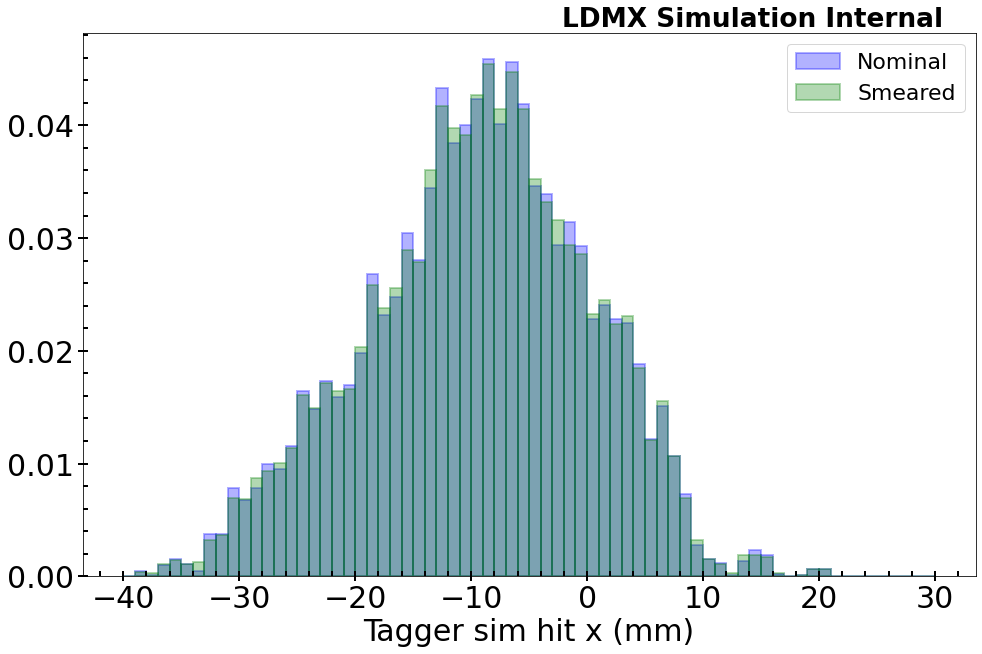

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10), 
                       facecolor='white')
draw_histogram1D(ax, tag_x, -40, 30, 71, 
                 x_label='Tagger sim hit x (mm)', norm=1, 
                 label='Nominal')
draw_histogram1D(ax, stag_x, -40, 30, 71, norm=1, color='green', 
                 edgecolor='green', label='Smeared')

ax.legend();

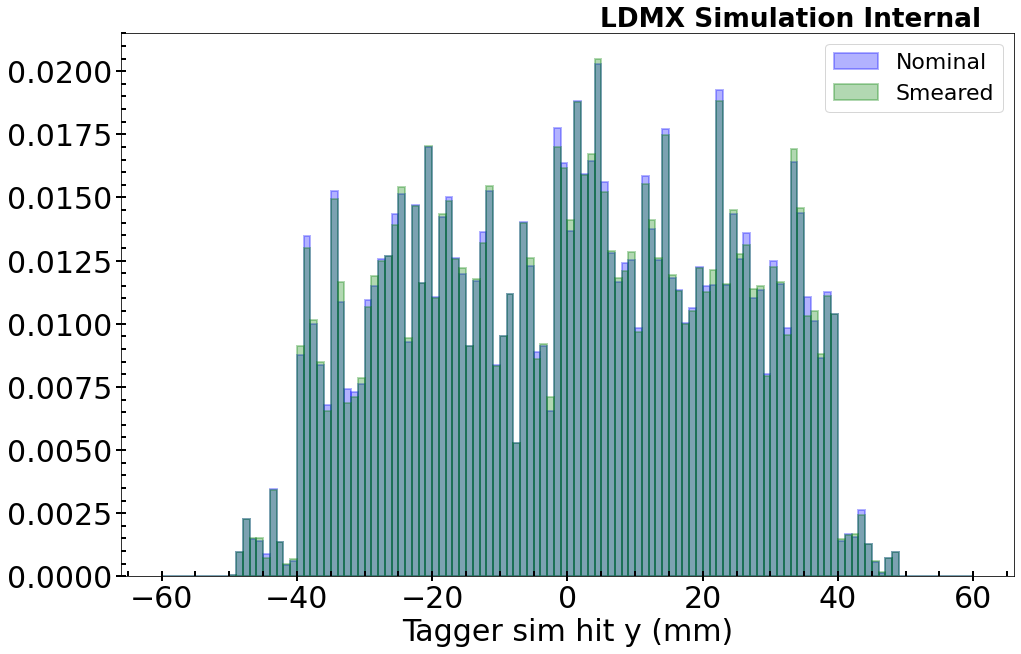

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10), 
                       facecolor='white')
draw_histogram1D(ax, tag_y, -60, 60, 121, 
                 x_label='Tagger sim hit y (mm)', norm=1, 
                 label='Nominal')
draw_histogram1D(ax, stag_y, -60, 60, 121, norm=1, color='green', 
                 edgecolor='green', label='Smeared')

ax.legend();

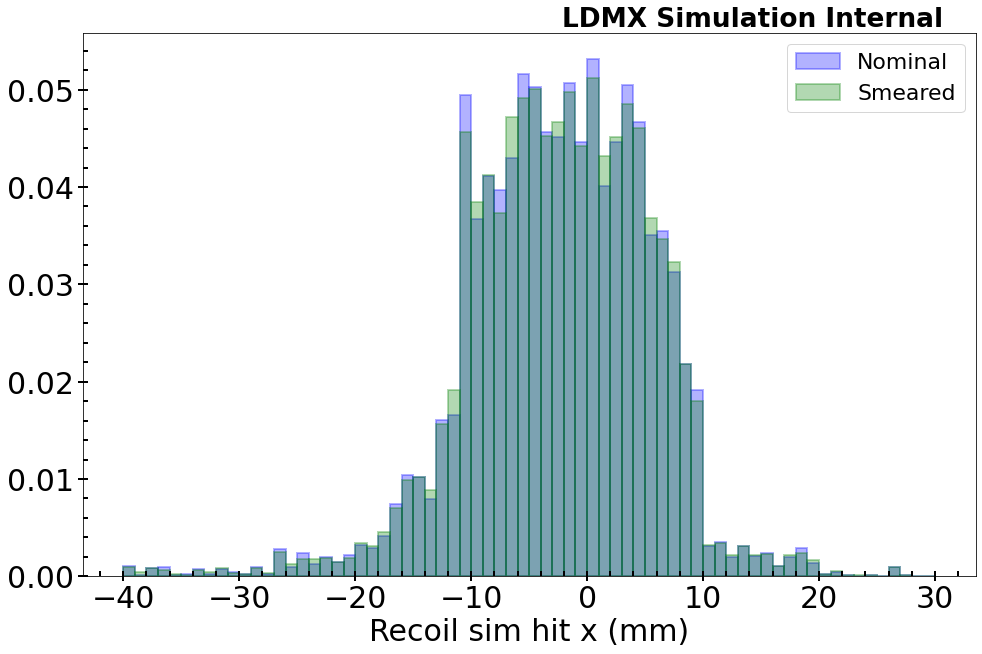

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10), 
                       facecolor='white')
draw_histogram1D(ax, rec_x, -40, 30, 71, 
                 x_label='Recoil sim hit x (mm)', norm=1, 
                 label='Nominal')
draw_histogram1D(ax, srec_x, -40, 30, 71, norm=1, color='green', 
                 edgecolor='green', label='Smeared')

ax.legend();

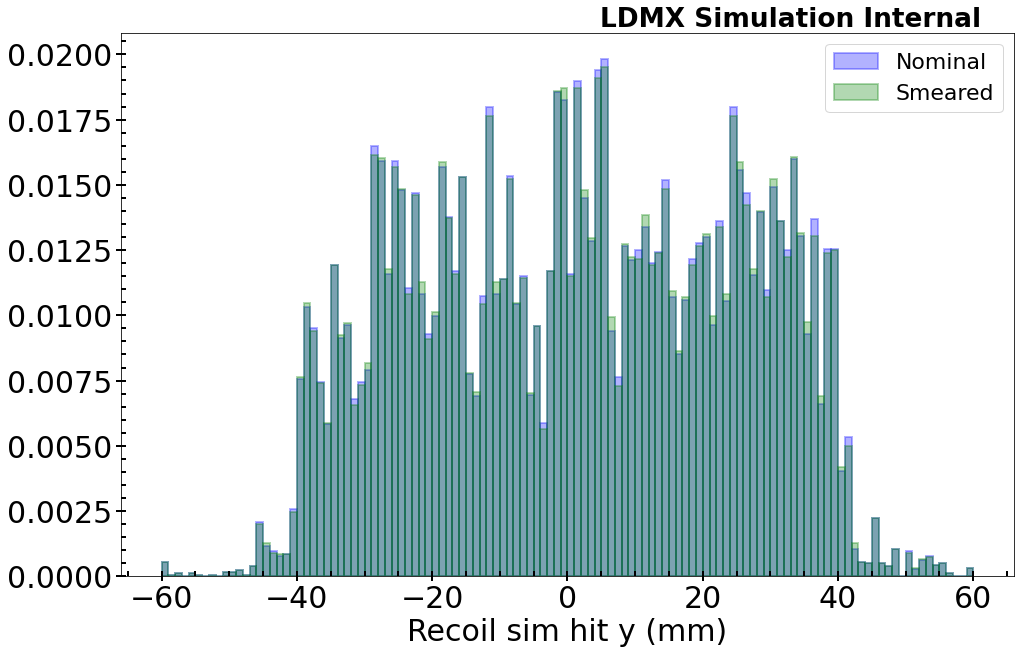

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10), 
                       facecolor='white')
draw_histogram1D(ax, rec_y, -60, 60, 121, 
                 x_label='Recoil sim hit y (mm)', norm=1, 
                 label='Nominal')
draw_histogram1D(ax, srec_y, -60, 60, 121, norm=1, color='green', 
                 edgecolor='green', label='Smeared')

ax.legend();

Tagger x: mu: -0.0007361162590689631, sigma: 0.2515589220937771
Recoil x: mu: -0.001479656809688472, sigma: 0.2507604791951836


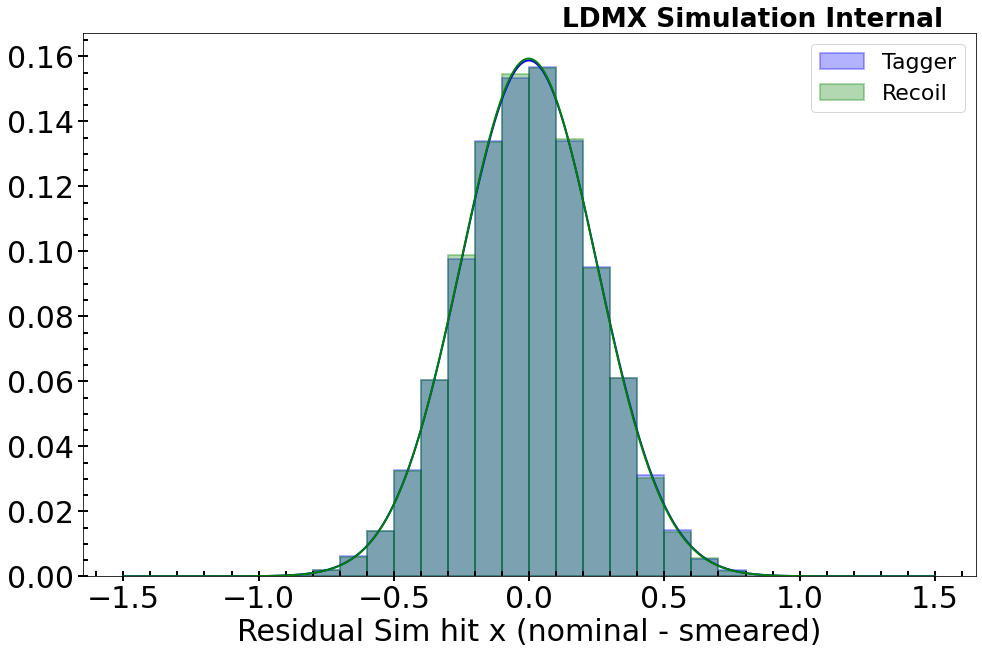

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10), 
                       facecolor='white')


bin_heights, bin_centers = draw_histogram1D(ax, tag_xres, -1.5, 1.5, 31, 
                 x_label='Residual Sim hit x (nominal - smeared)',
                 norm=1, label='Tagger')

mean, sigma = gaussian_fit(ax, -1.5, 1.5, bin_centers, bin_heights)
print('Tagger x: mu: %s, sigma: %s' % (mean, sigma))


bin_heights, bin_centers = draw_histogram1D(ax, rec_xres, -1.5, 1.5, 31,
                 norm=1, color='green', 
                 edgecolor='green', label='Recoil')
mean, sigma = gaussian_fit(ax, -1.5, 1.5, bin_centers, bin_heights,
                           color='green')
print('Recoil x: mu: %s, sigma: %s' % (mean, sigma))

ax.legend();

Tagger y: mu: 0.00022456618962143825, sigma: 0.05042593235317062
Recoil y: mu: 0.00011697644113367633, sigma: 0.050591589267597006


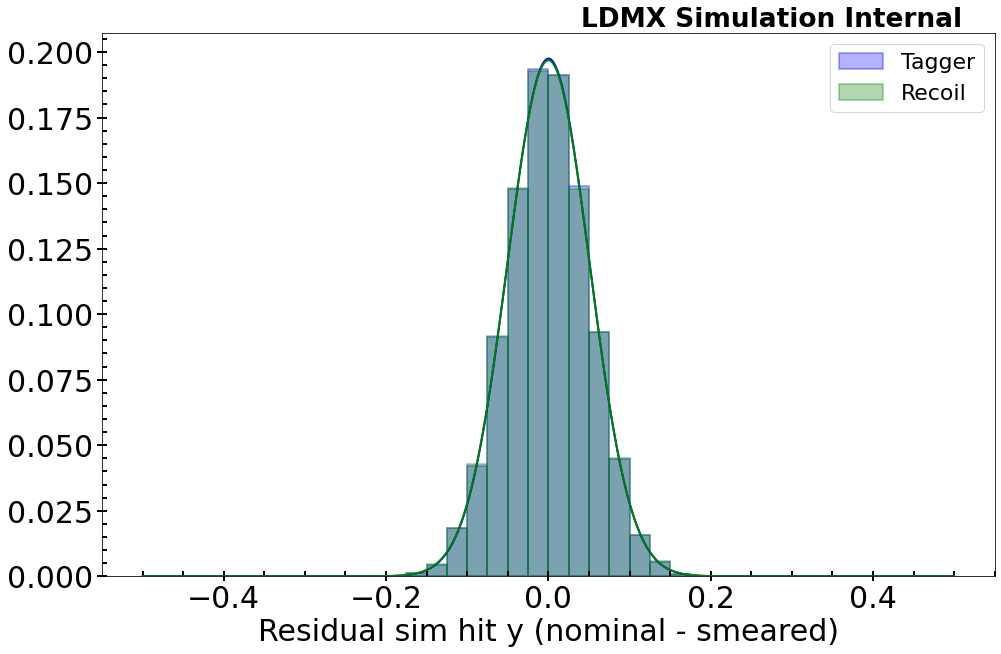

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10), 
                       facecolor='white')

x_fit_interval = np.linspace(-.5, .5, 200)

bin_heights, bin_centers = draw_histogram1D(ax, tag_yres, -.5, .5, 41, 
                 x_label='Residual sim hit y (nominal - smeared)',
                 norm=1, label='Tagger')
mean, sigma = gaussian_fit(ax, -.5, .5, bin_centers, bin_heights)
print('Tagger y: mu: %s, sigma: %s' % (mean, sigma))


bin_heights, bin_centers =  draw_histogram1D(ax, rec_yres, -.5, .5, 41, 
                 norm=1, label='Recoil', color='green', 
                 edgecolor='green')
mean, sigma = gaussian_fit(ax, -.5, .5, bin_centers, bin_heights,
                           color='green')
print('Recoil y: mu: %s, sigma: %s' % (mean, sigma))

ax.legend();